## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
print(len(fmnist_dataset_train))
print(len(fmnist_dataset_test))

60000
10000


torch.Size([128, 1, 28, 28])
torch.Size([128])
128


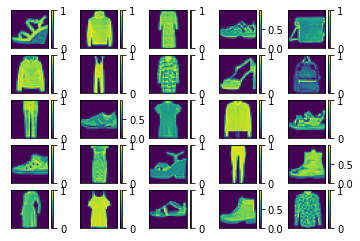

In [6]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    print(label.size(0))
    plt.rcParams['figure.figsize'] = [14, 14]
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img[i].reshape((28,28)))
        plt.colorbar()
    break

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─BatchNorm1d: 2-2                  [-1, 784]                 1,568
|    └─Linear: 2-3                       [-1, 128]                 100,480
|    └─ReLU: 2-4                         [-1, 128]                 --
|    └─Linear: 2-5                       [-1, 64]                  8,256
|    └─Tanh: 2-6                         [-1, 64]                  --
|    └─Linear: 2-7                       [-1, 10]                  650
Total params: 110,954
Trainable params: 110,954
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─BatchNorm1d: 2-2                  [-1, 784]                 1,568
|    └─Linear: 2-3                       [-1, 128]                 100,480
|    └─ReLU: 2-4                         [-1, 128]                 --
|    └─Linear: 2-5                       [-1, 64]                  8,256
|    └─Tanh: 2-6                         [-1, 64]                  --
|    └─Linear: 2-7                       [-1, 10]                  650
Total params: 110,954
Trainable params: 110,954
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43

Your experiments come here:

In [9]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
i = 0
losses = []
accuracy = 0
for epoch in range(8):
    for img, label in train_loader:
        opt.zero_grad()
        img = img.to(device)
        label = label.to(device)
        out = model(img)
        loss = loss_func(out, label)
        loss.backward()
        opt.step()
        i+=1
        losses.append(loss.item())
        if i % 100 == 0:
            accuracy = 0
            for img, label in test_loader:
                img = img.to(device)
                label = label.to(device)
                out = model(img)
                accuracy += (torch.argmax(out, dim=1) == label).sum().item()
            accuracy /= len(fmnist_dataset_test)
            print('Epoch: ', epoch, 'Iteration: ', i, 'Loss: ', loss.item(), 'Accuracy: ', accuracy)

Epoch:  0 Iteration:  100 Loss:  0.5552829504013062 Accuracy:  0.8071
Epoch:  0 Iteration:  200 Loss:  0.607063889503479 Accuracy:  0.8381
Epoch:  0 Iteration:  300 Loss:  0.2724768817424774 Accuracy:  0.842
Epoch:  0 Iteration:  400 Loss:  0.3850288689136505 Accuracy:  0.8498
Epoch:  1 Iteration:  500 Loss:  0.2818242609500885 Accuracy:  0.8558
Epoch:  1 Iteration:  600 Loss:  0.34943878650665283 Accuracy:  0.8596
Epoch:  1 Iteration:  700 Loss:  0.28093039989471436 Accuracy:  0.8654
Epoch:  1 Iteration:  800 Loss:  0.32131895422935486 Accuracy:  0.861
Epoch:  1 Iteration:  900 Loss:  0.31364336609840393 Accuracy:  0.8612
Epoch:  2 Iteration:  1000 Loss:  0.4425944983959198 Accuracy:  0.8683
Epoch:  2 Iteration:  1100 Loss:  0.40508243441581726 Accuracy:  0.8614
Epoch:  2 Iteration:  1200 Loss:  0.2678925395011902 Accuracy:  0.8669
Epoch:  2 Iteration:  1300 Loss:  0.33040034770965576 Accuracy:  0.8697
Epoch:  2 Iteration:  1400 Loss:  0.2503417432308197 Accuracy:  0.8771
Epoch:  3 It

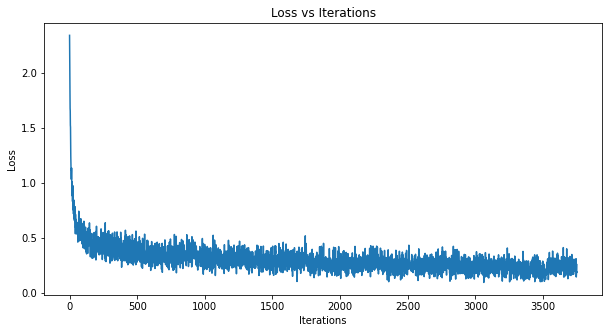

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.show()


In [11]:
with torch.no_grad():
    acum = 0
    for img, label in test_loader:
        img = img.to(device)
        out = model(img)
        out = torch.argmax(out, dim=1)
        label = label.to(device)
        accuracy = (out == label).sum().item() / label.size(0)
        acum += accuracy
    print('Average accuracy:', acum / len(test_loader))

Average accuracy: 0.8875


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [12]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
        

In [13]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 128]                 100,480
|    └─ReLU: 2-3                         [-1, 128]                 --
|    └─Linear: 2-4                       [-1, 64]                  8,256
|    └─Tanh: 2-5                         [-1, 64]                  --
|    └─Linear: 2-6                       [-1, 10]                  650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 128]                 100,480
|    └─ReLU: 2-3                         [-1, 128]                 --
|    └─Linear: 2-4                       [-1, 64]                  8,256
|    └─Tanh: 2-5                         [-1, 64]                  --
|    └─Linear: 2-6                       [-1, 10]                  650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42

In [14]:
def train(model, train_loader, test_loader, loss_func, opt, epochs=10):
    i = 0
    losses_train = []
    losses_test = []
    iterations = []
    accuracies_train = []
    accuracies_test = []

    for epoch in range(epochs):
        acum_train = 0
        for size, (img, label) in enumerate(train_loader):
            opt.zero_grad()
            img = img.to(device)
            label = label.to(device)

            out = model(img)
            loss = loss_func(out, label)
            loss.backward()
            opt.step()

            i += 1
            accuracy_train = (torch.argmax(out, dim=1) == label).sum().item() / label.size(0)
            acum_train += accuracy_train
            losses_train.append(loss.item())

            if i%100 == 0:
                acum_test = 0
                for img, label in test_loader:
                    img = img.to(device)
                    label = label.to(device)
                    out = model(img)

                    loss_test = loss_func(out, label)
                    label = label.to(device)
                    out = torch.argmax(out, dim=1)
                    accuracy_test = (out == label).sum().item() / label.size(0)
                    acum_test += accuracy_test
                    
                iterations.append(i)
                losses_test.append(loss_test.item())
                accuracies_train.append(acum_train / (size + 1))
                accuracies_test.append(acum_test / len(test_loader))
                    
                if i % 400 == 0:
                    print('Epoch: ', epoch, 'Iteration: ', i, 'Loss: ', loss.item(), 'Accuracy train: ', acum_train / (size + 1), 'Accuracy test: ', acum_test / len(test_loader))
                if acum_train / (size + 1) > 0.92:
                    return iterations, losses_train, losses_test, accuracies_train, accuracies_test
    return iterations, losses_train, losses_test, accuracies_train, accuracies_test


In [15]:
import random
fmnist_dataset_train_overfit = torch.utils.data.Subset(fmnist_dataset_train, random.sample(range(0, len(fmnist_dataset_train)), 10000))
train_loader_overfit = torch.utils.data.DataLoader(fmnist_dataset_train_overfit, 
                                           batch_size=10,
                                           shuffle=True,
                                           num_workers=2)

model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

iterations, losses_train, losses_test, accuracies_train, accuracies_test = train(model, train_loader_overfit, test_loader, loss_func, opt, epochs=14)

Epoch:  0 Iteration:  400 Loss:  0.6134077906608582 Accuracy train:  0.6995 Accuracy test:  0.77255859375
Epoch:  0 Iteration:  800 Loss:  0.4756280481815338 Accuracy train:  0.7472499999999982 Accuracy test:  0.7802734375
Epoch:  1 Iteration:  1200 Loss:  1.243793249130249 Accuracy train:  0.815500000000001 Accuracy test:  0.825390625
Epoch:  1 Iteration:  1600 Loss:  0.14163097739219666 Accuracy train:  0.822166666666665 Accuracy test:  0.8201171875
Epoch:  1 Iteration:  2000 Loss:  0.33474475145339966 Accuracy train:  0.8338999999999934 Accuracy test:  0.77021484375
Epoch:  2 Iteration:  2400 Loss:  0.3553372323513031 Accuracy train:  0.8472500000000004 Accuracy test:  0.83291015625
Epoch:  2 Iteration:  2800 Loss:  0.3999142646789551 Accuracy train:  0.8487499999999951 Accuracy test:  0.83310546875
Epoch:  3 Iteration:  3200 Loss:  1.079848051071167 Accuracy train:  0.8600000000000013 Accuracy test:  0.82197265625
Epoch:  3 Iteration:  3600 Loss:  0.5209122896194458 Accuracy train:

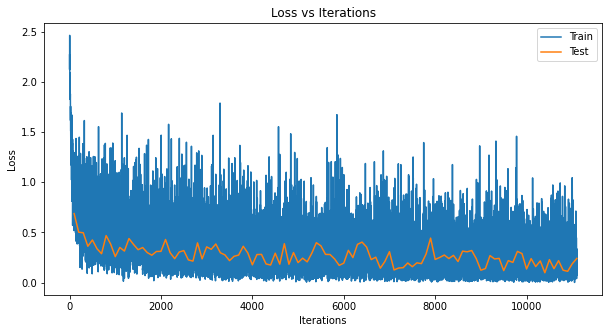

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(losses_train)), losses_train, label='Train')
plt.plot(iterations, losses_test, label='Test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.legend()
plt.show()


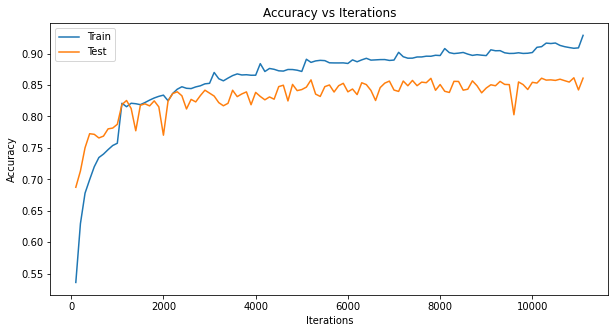

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(iterations, accuracies_train, label='Train')
plt.plot(iterations, accuracies_test, label='Test')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iterations')
plt.legend()
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [18]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Dropout(),
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [19]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Dropout: 2-2                      [-1, 784]                 --
|    └─BatchNorm1d: 2-3                  [-1, 784]                 1,568
|    └─Linear: 2-4                       [-1, 128]                 100,480
|    └─ReLU: 2-5                         [-1, 128]                 --
|    └─BatchNorm1d: 2-6                  [-1, 128]                 256
|    └─Linear: 2-7                       [-1, 64]                  8,256
|    └─Tanh: 2-8                         [-1, 64]                  --
|    └─Linear: 2-9                       [-1, 10]                  650
Total params: 111,210
Trainable params: 111,210
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.44

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Dropout: 2-2                      [-1, 784]                 --
|    └─BatchNorm1d: 2-3                  [-1, 784]                 1,568
|    └─Linear: 2-4                       [-1, 128]                 100,480
|    └─ReLU: 2-5                         [-1, 128]                 --
|    └─BatchNorm1d: 2-6                  [-1, 128]                 256
|    └─Linear: 2-7                       [-1, 64]                  8,256
|    └─Tanh: 2-8                         [-1, 64]                  --
|    └─Linear: 2-9                       [-1, 10]                  650
Total params: 111,210
Trainable params: 111,210
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.44

In [21]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()

iterations, losses_train, losses_test, accuracies_train, accuracies_test = train(model, train_loader, test_loader, loss_func, opt, epochs=10)


Epoch:  0 Iteration:  400 Loss:  0.6601521968841553 Accuracy train:  0.785625 Accuracy test:  0.81015625
Epoch:  1 Iteration:  800 Loss:  0.3799715042114258 Accuracy train:  0.8242777567975831 Accuracy test:  0.82412109375
Epoch:  2 Iteration:  1200 Loss:  0.3648940622806549 Accuracy train:  0.8397244751908397 Accuracy test:  0.83408203125
Epoch:  3 Iteration:  1600 Loss:  0.42164480686187744 Accuracy train:  0.8461382772020726 Accuracy test:  0.8322265625
Epoch:  4 Iteration:  2000 Loss:  0.44088295102119446 Accuracy train:  0.848601310483871 Accuracy test:  0.83896484375
Epoch:  5 Iteration:  2400 Loss:  0.32624536752700806 Accuracy train:  0.8556818181818182 Accuracy test:  0.842578125
Epoch:  5 Iteration:  2800 Loss:  0.43172547221183777 Accuracy train:  0.8532451923076924 Accuracy test:  0.84326171875
Epoch:  6 Iteration:  3200 Loss:  0.4093853831291199 Accuracy train:  0.8567640867875648 Accuracy test:  0.84609375
Epoch:  7 Iteration:  3600 Loss:  0.33337798714637756 Accuracy tra

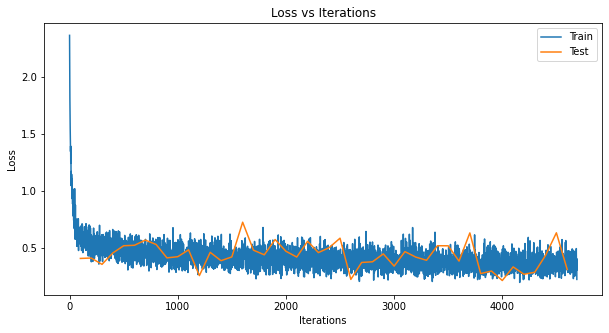

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses_train)), losses_train, label='Train')
plt.plot(iterations, losses_test, label='Test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.legend()
plt.show()


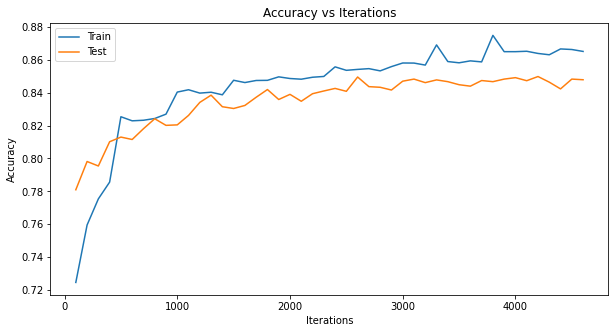

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(iterations, accuracies_train, label='Train')
plt.plot(iterations, accuracies_test, label='Test')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iterations')
plt.legend()
plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

The amount of epochs used to train a model definitely affects on the overfitting of the data.<br>

Also things like dropout and batchnorm really helped to get less overfitting, demonstrating how good these tools are to get a better model.

In the plots seen before is quite obvious that as the epochs go up, so does the accuracy for train data, meaning overfitting.<br>
In the fixed case, the accuracy stays about the same values, meaning we got close to some convergence point.
